In [1]:
import sys
sys.path.append('..')

import pandas as pd
import gc
import torch
import torchaudio
from torch.utils.data import Dataset, DataLoader
from utils.datapreprocessor import SoapiePreprocessor
from utils.datasets import dataset_dict, speech_file_to_array_fn, get_random_elements, down_sample_labels_fn

/home/gfrost/anaconda3/envs/penguin/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Dataframes

In [4]:
engzul_preprocessor = SoapiePreprocessor(lang_pair='cs_engzul', corpora_dir='/home/gfrost/datasets/soapies_balanced_corpora/')

In [5]:
df_train, df_dev, df_test = engzul_preprocessor.generate_split_dataframes(save_csv=True)

100%|██████████| 768/768 [00:07<00:00, 102.42it/s]


In [7]:
del df_train, df_dev, df_test
gc.collect()

690

### Dataset construction

In [2]:
path = '/home/gfrost/datasets/soapies_balanced_corpora/cs_engxho_balanced/lang_targs_mult/cs_engxho_trn.pkl'
df_trn = pd.read_pickle(path)
# path = '/media/geoff/datasets/soapies_balanced_corpora/cs_engzul_balanced/lang_targs_mult/cs_engzul_dev.pkl'
# df_dev = pd.read_pickle(path)
# path = '/media/geoff/datasets/soapies_balanced_corpora/cs_engzul_balanced/lang_targs_mult/cs_engzul_tst.pkl'
# df_tst = pd.read_pickle(path)

# dataset = dataset_dict(df_trn, df_dev, df_tst)

# del df_trn, df_dev, df_tst
# gc.collect()

In [3]:
df_trn.head()

,audio_fpath,tgts
0,//home/gfrost/datasets/soapies_balanced_corpor...,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ..."
1,//home/gfrost/datasets/soapies_balanced_corpor...,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ..."
2,//home/gfrost/datasets/soapies_balanced_corpor...,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ..."
3,//home/gfrost/datasets/soapies_balanced_corpor...,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ..."
4,//home/gfrost/datasets/soapies_balanced_corpor...,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ..."


In [4]:
ds_train = dataset['train'].to_pandas()
ds_train.head()

,audio_fpath,tgts,ds_tgts
0,/media/geoff/datasets/soapies_balanced_corpora...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
1,/media/geoff/datasets/soapies_balanced_corpora...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
2,/media/geoff/datasets/soapies_balanced_corpora...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
3,/media/geoff/datasets/soapies_balanced_corpora...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
4,/media/geoff/datasets/soapies_balanced_corpora...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."


In [5]:
from torch.nn.utils.rnn import pad_sequence

class CSDataset(Dataset):
    def __init__(self, ds_train, transform=False):
        self.transform = transform
        self.ds_train = ds_train

        #self.audio_path = dataset['audio_fpath']
        #self.speech = dataset['speech']
        #self.target = dataset['ds_tgts']
    
    def __len__(self):
        return len(self.ds_train)
    
    def __getitem__(self, idx):
        audio, sr = torchaudio.load(self.ds_train.audio_fpath.iloc[idx])
        #audio = self.speech[idx][0]
        if self.transform:
            pass
        return audio[0], torch.tensor(self.ds_train.ds_tgts.iloc[idx], dtype=torch.long)

def collator(batch):
    xx = [s[0] for s in batch]
    xx_ll = [len(s[0]) for s in batch]
    yy = [s[1] for s in batch]
    yy_ll = [len(s[1]) for s in batch]

    xx_ll = torch.tensor(xx_ll, dtype=torch.float)
    yy_ll = torch.tensor(yy_ll, dtype=torch.float)

    return pad_sequence(xx, batch_first=True), xx_ll, pad_sequence(yy, batch_first=True, padding_value=1), yy_ll

In [6]:
dataset_trn = CSDataset(ds_train)

In [23]:
# from torch.utils.data.sampler import BatchSampler, RandomSampler
# sampler = BatchSampler(RandomSampler(dataset_trn), batch_size=16, drop_last=False)

In [7]:
train_dataloader = DataLoader(dataset_trn, batch_size=16, collate_fn=collator, num_workers=12)

In [19]:
import time

start = time.perf_counter()

for i, batch in enumerate(train_dataloader):
    x, x_l, y, y_l = batch
    
    # print(x.shape)
    # print(x_l.shape)
    # print(y.shape)
    # print(y_l.shape)
    #break

end = time.perf_counter()
print(start-end)

tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]])
tensor([124., 141., 110.,  96.,  91., 217.,  93., 166.,  89., 117., 108., 102.,
        105.,  82.,  88., 137.])
tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]])
tensor([ 81.,  81., 101.,  80.,  85.,  98.,  90., 102., 100.,  23.,  85.,  84.,
         81.,  90.,  82.,  87.])
tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [2, 2, 2,  ..., 1, 1, 1],
        [2, 2, 2,  ..., 1, 1, 1],
        [2, 2, 2,  ..., 1, 1, 1]])
tensor([127., 102., 150.,  16.,  31.,  22.,  21.,  14.,   9.,  16.,  11.,  12.,
         12.,  28.,  29.,  30.])
tensor(

In [8]:
import sys
sys.path.append('..')
import pandas as pd
import os
from utils.datasets import read_pickle_df, load_dfs

In [10]:
df_trn, df_dev = load_dfs('/home/gfrost/datasets/soapies_balanced_corpora/cs_engzul_balanced/lang_targs_mult', 'engzul')
melspec_extractor = torchaudio.transforms.MelSpectrogram(n_fft=400, hop_length=160, n_mels=23)


In [23]:
path = df_trn.iloc[0, 0]
audio, sr = torchaudio.load(path)
melspec = torch.log10(melspec_extractor(audio))

In [35]:
melspec[0].T

tensor([[-1.7193, -1.6314, -1.4608,  ..., -2.3122, -2.3373, -2.6923],
        [-1.9602, -1.5946, -1.9128,  ..., -2.2743, -2.4106, -2.8308],
        [-2.5066, -1.5085, -1.5238,  ..., -3.0124, -3.1551, -3.1431],
        ...,
        [-1.4475, -0.7869, -0.8805,  ..., -1.4877, -1.4942, -1.6345],
        [-2.1230, -1.0279, -1.2722,  ..., -2.0548, -1.8716, -2.0129],
        [-1.7609, -1.1396, -0.8030,  ..., -2.0373, -2.2447, -2.1514]])

In [31]:
melspec[0].T.shape

torch.Size([532, 23])

In [46]:
melspec[0].shape

torch.Size([23, 532])

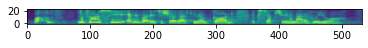

In [44]:
import matplotlib.pyplot as plt

plt.imshow(melspec[0], origin='lower')

In [5]:
import torch
import sys
sys.path.append('..')

In [6]:
ckpt = torch.load('../logs/lightning_logs/version_66/checkpoints/15-0.00-0.00.ckpt')

In [8]:
ckpt['state_dict']

OrderedDict([('backbone.mask_emb',
              tensor([-0.2944, -0.0399,  0.1719,  ...,  0.0889, -0.1373,  0.4500],
                     device='cuda:0')),
             ('backbone.feature_extractor.conv_layers.0.0.weight',
              tensor([[[ 0.0007, -0.0043,  0.0040,  ...,  0.0075,  0.0019,  0.0009]],
              
                      [[ 0.0014, -0.0040,  0.0039,  ...,  0.0068,  0.0018,  0.0010]],
              
                      [[ 0.0143,  0.0028,  0.0139,  ..., -0.0103, -0.0482,  0.0603]],
              
                      ...,
              
                      [[ 0.0100, -0.0367,  0.0694,  ..., -0.0900,  0.0567, -0.0154]],
              
                      [[ 0.0011, -0.0047,  0.0034,  ...,  0.0071,  0.0012,  0.0005]],
              
                      [[ 0.0011, -0.0041,  0.0039,  ...,  0.0066,  0.0014,  0.0006]]],
                     device='cuda:0')),
             ('backbone.feature_extractor.conv_layers.0.2.1.weight',
              tensor([0.1857, 0.

In [9]:
import numpy as np

np.sum(np.gradient([0,0,0,0,1,1,1,1,1]))

array([0. , 0. , 0. , 0.5, 0.5, 0. , 0. , 0. , 0. ])

### Double check mixup

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

import sys
sys.path.append('..')

from utils.transforms import interp_targets, powspace, SpecAugment, MixUp, AudioTransforms
from utils.datasets import create_dataloaders, load_dfs
from models.lit_cs_detector import LitCSDetector, ModelConfig, get_padding_masks_from_length
from utils.transforms import MixUp, interp_targets


/home/gfrost/anaconda3/envs/penguin/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_dir="/home/gfrost/datasets"
supported_cs_pairs=["engzul", "engxho", "engtsn", "engsot"]

dfs_trn = []
dfs_dev = []

for cs_pair in supported_cs_pairs:
    data_df_root_dir = os.path.join(data_dir, \
        f"soapies_balanced_corpora/cs_{cs_pair}_balanced/lang_targs_mult/")
    df_trn, df_dev = load_dfs(data_df_root_dir, cs_pair, True)
    dfs_trn.append(df_trn)
    dfs_dev.append(df_dev)
df_trn = pd.concat(dfs_trn)
df_dev = pd.concat(dfs_dev)

In [3]:
cfg = ModelConfig()
cfg.backbone = 'wavlm-large'
cfg.n_classes = 5

train_dataloader, dev_dataloader = create_dataloaders(df_trn, df_dev, bs=4, num_workers=4)
model = LitCSDetector(model_config=cfg)

mixer = MixUp(mixup_prob=1.0, mixup_size=1.0, beta_min=1.0, beta_max=1.0)

In [4]:
for batch in train_dataloader:
    with torch.no_grad():
        x, l, y, y_l = batch

        print(y.max())

        padding_masks = get_padding_masks_from_length(x, l)
        x, padding_masks, lengths = model.backbone.custom_feature_extractor(x, padding_masks)

        y = interp_targets(y, torch.max(lengths))

        print(y.max())

        y_old = y
        x_old = x.clone()
        x, y = mixer.forward(x, lengths, 
                            F.one_hot(y.to(torch.long), num_classes=5).float())

        print(torch.argmax(y, dim=-1).max())

    break

tensor(2)
tensor(2)
tensor(2)


In [5]:
y_old = F.one_hot(y_old.to(torch.long), num_classes=5).float()

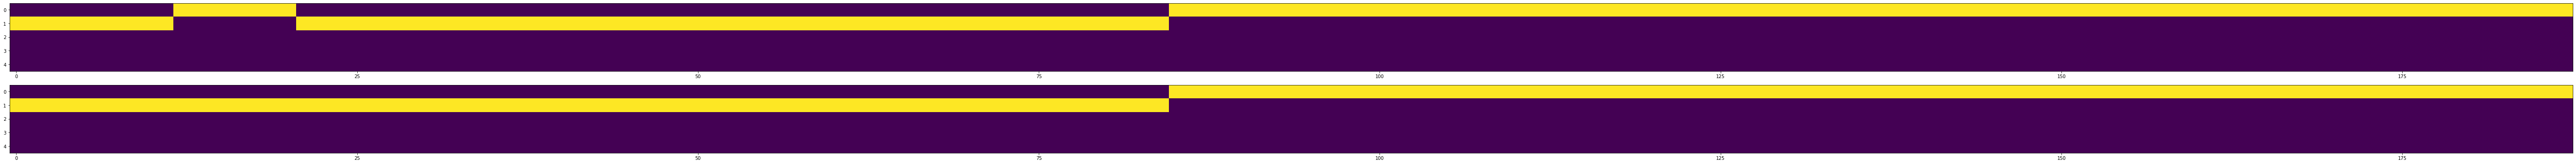

In [6]:
from matplotlib.pyplot import figure
#figure(figsize=(100, 6), dpi=300)

fig, ax = plt.subplots(2, 1, figsize=(100, 6))
idx = 3

ax[0].imshow(y[idx].T)
ax[1].imshow(y_old[idx].T)

# plt.imshow(y[idx].T - y_old[idx].T)

### Double check melspec dataloader

In [8]:
import sys
sys.path.append('..')

import torchmetrics.functional as FM
import torch.nn.functional as F
import torch
from models.lit_cs_detector import LitCSDetector, get_unpadded_idxs
from utils.transforms import interp_targets
from utils.datasets import load_dfs, create_dataloaders, stack_melspecs, part_segments
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import math

In [31]:
data_dir="/home/gfrost/datasets"
supported_cs_pairs = ["engzul", "engxho", "engtsn", "engsot"]

dfs_dev = []
dfs_trn = []

for cs_pair in supported_cs_pairs:
    
    data_df_root_dir = os.path.join(data_dir, \
        f"soapies_balanced_corpora/cs_{cs_pair}_balanced/lang_targs_mult/")
    
    df_trn, df_dev = load_dfs(data_df_root_dir, cs_pair, all_cs_pairs=True, lang_fams=False)
    
    dfs_dev.append(df_dev)
    dfs_trn.append(df_trn)

df_dev = pd.concat(dfs_dev)
df_trn = pd.concat(dfs_trn)

train_dataloader, dev_dataloader = create_dataloaders(df_trn, df_dev, melspecs=True, stack_frames=False, bs=2, num_workers=4)

In [79]:
batch = iter(train_dataloader).next()
x, x_l, y, y_l = batch

In [80]:
x, y = x[0, :int(x_l[0])], y[0, :int(x_l[0])]

In [86]:
max_len = math.floor(x.size(0) / 19) * 19
print(max_len)

melspec = x[:max_len, :].view(-1, 19*x.size(-1))
label = y[:max_len].unsqueeze(-1).view(-1, 19)
label = torch.mode(label, dim=-1).values.long()

76


In [95]:
x[19:19*2].flatten() - melspec[1]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [87]:
melspec2 = melspec.reshape(melspec.size(0), 23, 19)

TypeError: Invalid shape (437,) for image data

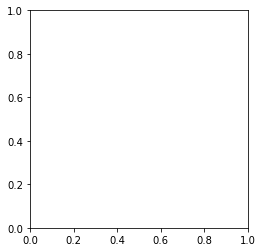

In [68]:
plt.imshow(melspec[0], origin='lower')

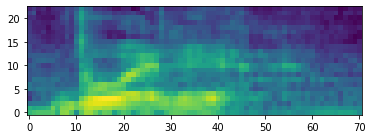

In [70]:
plt.imshow(x.T, origin='lower')

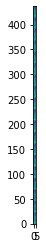

In [40]:
plt.imshow(x_comp.T, origin='lower')

In [50]:
x[0, 19:19*2].view(-1) - x_comp[0, 1]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 